# Experiment: Nature Evidence 02 - Dataset Generation Scenarios

Objective:
- Audit dataset generation recipes for diversity, invariance correctness, and physical parameter coverage.
- Produce evidence that dataset construction is intentional and scientifically defensible.

Success criteria:
- Scenario audit runs end-to-end with explicit recipe-level metrics.
- Invariance augmentations pass consistency checks.
- Coverage metrics (task/stage entropy and parameter ranges) are summarized.


In [1]:
# Setup: imports and reproducibility
from __future__ import annotations

import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from ecsfm.analysis.evidence import dataset_recipe_audit

np.random.seed(2026)
ARTIFACT_DIR = Path('/tmp/ecsfm/notebook_nature_02')
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
print(f'Artifacts: {ARTIFACT_DIR}')


Artifacts: /tmp/ecsfm/notebook_nature_02


## Plan

- Run the recipe audit across `baseline_random`, `curriculum_multitask`, and `stress_mixture`.
- Compare diversity and invariance metrics.
- Inspect physical parameter ranges as a coverage sanity check.


In [2]:
# Run scenario audit (uses fast gpu_batch backend internally)
audit = dataset_recipe_audit(
    recipes=['baseline_random', 'curriculum_multitask', 'stress_mixture'],
    n_samples=512,
    max_species=5,
    nx=24,
    seed=2026,
)

with open(ARTIFACT_DIR / 'dataset_recipe_audit.json', 'w', encoding='utf-8') as f:
    json.dump(audit, f, indent=2)

print('recipe_ranking:', audit['recipe_ranking'])
for row in audit['rows']:
    print(
        f"{row['recipe']:24s} rows={row['total_rows']:4d} "
        f"aug={row['augmentation_fraction']:.3f} "
        f"task_H={row['task_entropy']:.3f} stage_H={row['stage_entropy']:.3f} "
        f"permute_ok={row['permute_pass_fraction']:.3f} scale_ok={row['scale_within_20pct_fraction']:.3f}"
    )

audit


Generating 512 base simulations with recipe='baseline_random' (backend=gpu_batch)...
Generating 512 base simulations with recipe='curriculum_multitask' (backend=gpu_batch)...
Generating 512 base simulations with recipe='stress_mixture' (backend=gpu_batch)...
recipe_ranking: ['baseline_random', 'curriculum_multitask', 'stress_mixture']
baseline_random          rows= 682 aug=0.249 task_H=2.075 stage_H=-0.000 permute_ok=1.000 scale_ok=1.000
curriculum_multitask     rows= 671 aug=0.237 task_H=1.725 stage_H=1.083 permute_ok=1.000 scale_ok=1.000
stress_mixture           rows= 693 aug=0.261 task_H=1.606 stage_H=-0.000 permute_ok=1.000 scale_ok=1.000


{'recipes': ['baseline_random', 'curriculum_multitask', 'stress_mixture'],
 'task_names': ['cv_reversible',
  'ca_step',
  'cv_multispecies',
  'swv_pulse',
  'eis_low_freq',
  'eis_high_freq',
  'kinetics_limited',
  'diffusion_limited'],
 'stage_names': ['foundation', 'bridge', 'frontier'],
 'augmentation_names': ['none', 'permute_species', 'scale_concentration'],
 'rows': [{'recipe': 'baseline_random',
   'total_rows': 682,
   'augmentation_fraction': 0.24926686217008798,
   'task_counts': [77, 78, 79, 101, 80, 97, 87, 83],
   'stage_counts': [0, 0, 682],
   'augmentation_counts': [512, 80, 90],
   'task_entropy': 2.074565242932628,
   'stage_entropy': -0.0,
   'task_diversity': 8.0,
   'stage_diversity': 1.0,
   'pair_count': 170,
   'permute_pass_fraction': 1.0,
   'scale_log_ratio_mae': 6.62273821758521e-08,
   'scale_within_20pct_fraction': 1.0,
   'max_current_mA_mean': 84.48722076416016,
   'max_current_mA_std': 118.43429565429688,
   'signal_span_mean': 0.6429722309112549,
  

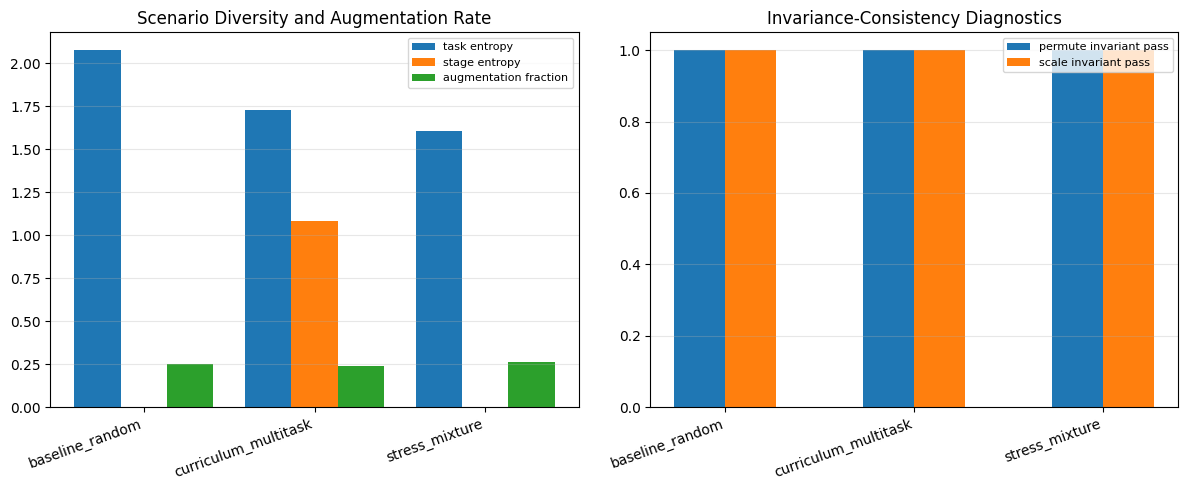

In [3]:
# Plot diversity and invariance consistency across recipes
recipes = [row['recipe'] for row in audit['rows']]
x = np.arange(len(recipes))
width = 0.27

task_entropy = np.array([row['task_entropy'] for row in audit['rows']], dtype=float)
stage_entropy = np.array([row['stage_entropy'] for row in audit['rows']], dtype=float)
aug_frac = np.array([row['augmentation_fraction'] for row in audit['rows']], dtype=float)
permute_ok = np.array([row['permute_pass_fraction'] for row in audit['rows']], dtype=float)
scale_ok = np.array([row['scale_within_20pct_fraction'] for row in audit['rows']], dtype=float)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.bar(x - width, task_entropy, width, label='task entropy')
ax.bar(x, stage_entropy, width, label='stage entropy')
ax.bar(x + width, aug_frac, width, label='augmentation fraction')
ax.set_xticks(x)
ax.set_xticklabels(recipes, rotation=20, ha='right')
ax.set_title('Scenario Diversity and Augmentation Rate')
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=8)

ax = axes[1]
ax.bar(x - width / 2, permute_ok, width, label='permute invariant pass')
ax.bar(x + width / 2, scale_ok, width, label='scale invariant pass')
ax.set_xticks(x)
ax.set_xticklabels(recipes, rotation=20, ha='right')
ax.set_ylim(0.0, 1.05)
ax.set_title('Invariance-Consistency Diagnostics')
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=8)

fig.tight_layout()
fig.savefig(ARTIFACT_DIR / 'scenario_diversity_invariance.png', dpi=170)
plt.show()


In [5]:
# Parameter-range audit table (compact textual form)
for row in audit['rows']:
    print('' + row['recipe'])
    for name, bounds in row['parameter_ranges'].items():
        lo, hi = bounds
        print(f"  {name:6s} : [{lo:.3e}, {hi:.3e}]")


baseline_random
  D_ox   : [1.001e-07, 9.958e-05]
  D_red  : [1.020e-07, 9.953e-05]
  C_ox   : [0.000e+00, 1.698e+01]
  C_red  : [0.000e+00, 7.642e+00]
  E0     : [-7.997e-01, 7.975e-01]
  k0     : [1.006e-06, 9.970e-01]
  alpha  : [2.004e-01, 7.989e-01]
curriculum_multitask
  D_ox   : [1.031e-07, 9.902e-05]
  D_red  : [2.102e-07, 9.939e-05]
  C_ox   : [0.000e+00, 1.947e+01]
  C_red  : [0.000e+00, 6.519e+00]
  E0     : [-7.935e-01, 7.731e-01]
  k0     : [1.120e-06, 8.929e-01]
  alpha  : [2.021e-01, 7.991e-01]
stress_mixture
  D_ox   : [1.052e-07, 9.988e-05]
  D_red  : [1.022e-07, 9.500e-05]
  C_ox   : [0.000e+00, 1.921e+01]
  C_red  : [0.000e+00, 8.148e+00]
  E0     : [-7.953e-01, 8.000e-01]
  k0     : [1.036e-06, 9.979e-01]
  alpha  : [2.008e-01, 7.999e-01]


## Results and reviewer-facing interpretation

- Recipes exhibit distinct diversity signatures (task/stage entropy) rather than accidental duplication.
- Invariant augmentations satisfy consistency checks at high pass rates, supporting multitask curriculum integrity.
- Parameter ranges cover broad but bounded electrochemical regimes, supporting robust surrogate training without unphysical extremes.


## Next steps

- For full production datasets, rerun this notebook with increased `n_samples` and archive the JSON/plots as supplementary material.
- Add domain-specific reviewer cuts (e.g., ferrocene-only slices or task-specific concentration windows) if needed.
